In [1]:
%matplotlib widget

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import ipywidgets as widgets
from IPython.display import display
import numpy as np

from aerometrics.paper.functions.metric_functions import ratr_contrails

## Dataset

In [2]:
file_path_distance = 'data/seg_length_km_GAIA_2019.nc'
ds_distance = xr.open_dataset(file_path_distance)
print(ds_distance)

file_path = 'data/EF_and_RF_per_contrail_length_2010_2019.nc'
ds = xr.open_dataset(file_path)
print(ds)

<xarray.Dataset> Size: 1MB
Dimensions:                 (lat: 180, lon: 360)
Coordinates:
  * lat                     (lat) float64 1kB -89.5 -88.5 -87.5 ... 88.5 89.5
  * lon                     (lon) float64 3kB 0.5 1.5 2.5 ... 357.5 358.5 359.5
Data variables:
    seg_length_km           (lat, lon) float64 518kB ...
    seg_length_contrail_km  (lat, lon) float64 518kB ...
<xarray.Dataset> Size: 29MB
Dimensions:       (year: 10, lat: 180, lon: 360)
Coordinates:
  * year          (year) int64 80B 2010 2011 2012 2013 ... 2016 2017 2018 2019
  * lat           (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon           (lon) float64 3kB 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
Data variables:
    RF_net        (year, lat, lon) float32 3MB ...
    areacella     (lat, lon) float64 518kB ...
    EF            (year, lat, lon) float64 5MB ...
    RF_lin_cotra  (year, lat, lon) float64 5MB ...
    RF_lin        (year, lat, lon) float64 5MB ...
    EF_lin_cotra  (year, lat

## Variability of sensitivity to emissions

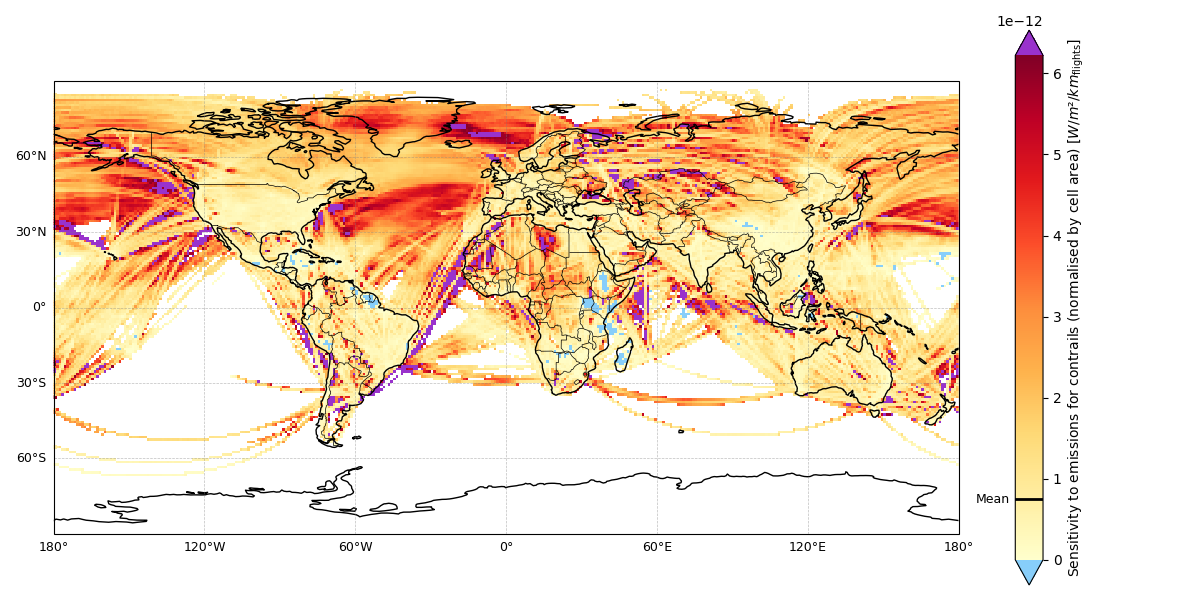

IntSlider(value=2019, description='Year', max=2019, min=2010)

In [3]:
def interactive_plot():
    
    slider = widgets.IntSlider(min=2010, max=2019, step=1, value=2019, description='Year')

    # Data
    year = slider.value
    rf_distance_year = ds.sel(year=year)['RF_net'] / ds_distance['seg_length_km']
    rf_distance_normalised_year = rf_distance_year.where(np.isfinite(rf_distance_year), np.nan) * ds['areacella'] / ds['areacella'].sum(dim=['lat','lon'])
    rf_distance_year_i = rf_distance_normalised_year * ds_distance['seg_length_km'].where(np.isfinite(ds_distance['seg_length_km']), np.nan) / ds_distance['seg_length_km'].sum(dim=['lat', 'lon']).item()
    mean_rf_distance_year = rf_distance_year_i.sum().item()

    minimal_traffic_per_cell=1e4
    data_masked_year = rf_distance_normalised_year.where(ds_distance['seg_length_km'] >= minimal_traffic_per_cell)
    data_np_year = data_masked_year.values

    # Bounds and norm
    vmin = 0
    vmax = data_masked_year.quantile(0.97)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

    # Colormap
    cmap = plt.cm.YlOrRd
    cmap.set_bad(color=(1,1,1,0))
    cmap.set_under('lightskyblue') 
    cmap.set_over('darkorchid')

    # Plot
    fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.set_global()

    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 9}
    gl.ylabel_style = {'size': 9}

    pcm = ax.pcolormesh(data_masked_year['lon'], data_masked_year['lat'], data_np_year,
                        cmap=cmap, norm=norm,
                        transform=ccrs.PlateCarree())

    cbar = fig.colorbar(pcm, ax=ax, extend='both')
    cbar.set_label(r"Sensitivity to emissions for contrails (normalised by cell area) [$W/m²/km_{\text{flights}}$]", fontsize=10)
    mean_line = cbar.ax.axhline(mean_rf_distance_year, color='black', linewidth=2)
    mean_text = cbar.ax.text(-0.2, mean_rf_distance_year, 'Mean', va='center', ha='right', color='black', fontsize=9,
                             transform=cbar.ax.get_yaxis_transform())

    fig.tight_layout()
    plt.show()

    # Update function
    def update(change):

        ## Data
        year = change['new']
        rf_distance_year = ds.sel(year=year)['RF_net'] / ds_distance['seg_length_km']
        rf_distance_normalised_year = rf_distance_year.where(np.isfinite(rf_distance_year), np.nan) * ds['areacella'] / ds['areacella'].sum(dim=['lat','lon'])
        rf_distance_year_i = rf_distance_normalised_year * ds_distance['seg_length_km'].where(np.isfinite(ds_distance['seg_length_km']), np.nan) / ds_distance['seg_length_km'].sum(dim=['lat', 'lon']).item()
        mean_rf_distance_year = rf_distance_year_i.sum().item()
        data_masked_year = rf_distance_normalised_year.where(ds_distance['seg_length_km'] >= minimal_traffic_per_cell)
        data_np_year = data_masked_year.values

        ## Plot
        pcm.set_array(data_np_year.ravel())
        pcm.set_clim(vmin=vmin, vmax=vmax)
        mean_line.set_ydata([mean_rf_distance_year, mean_rf_distance_year])
        mean_text.set_position((-0.2, mean_rf_distance_year))

        fig.canvas.draw_idle()

    slider.observe(update, names='value')
    display(slider)

interactive_plot()

## Mean radiative forcing

In [4]:
mean_rf_net = 0
for k in range(2010, 2020):
    mean_annual_rf_net = ((ds['RF_net'] * ds['areacella']).sel(year=k).sum(dim=['lat', 'lon']).item() / ds['areacella'].sum(dim=['lat','lon']) * 1000).item()
    mean_rf_net += mean_annual_rf_net
    print("Radiative forcing for", k, "weather:", round(mean_annual_rf_net, 1), "mW/m²")

print("Mean radiative forcing:", round(mean_rf_net/10, 1), "mW/m²")

Radiative forcing for 2010 weather: 43.0 mW/m²
Radiative forcing for 2011 weather: 40.8 mW/m²
Radiative forcing for 2012 weather: 43.4 mW/m²
Radiative forcing for 2013 weather: 43.6 mW/m²
Radiative forcing for 2014 weather: 44.2 mW/m²
Radiative forcing for 2015 weather: 46.0 mW/m²
Radiative forcing for 2016 weather: 44.3 mW/m²
Radiative forcing for 2017 weather: 45.0 mW/m²
Radiative forcing for 2018 weather: 44.2 mW/m²
Radiative forcing for 2019 weather: 45.6 mW/m²
Mean radiative forcing: 44.0 mW/m²


## Generation of an updated NC file with mean and new data

In [5]:
mean_vars = {}
for var in ds.data_vars:
    if "year" in ds[var].dims:
        mean_vars[var] = ds[var].mean(dim="year")
    else:
        mean_vars[var] = ds[var]

ds_new = xr.Dataset(mean_vars, coords={"lat": ds.lat, "lon": ds.lon})

ds_new['seg_length_km'] = ds_distance['seg_length_km']
ds_new['seg_length_contrail_km'] = ds_distance['seg_length_contrail_km']
    
ds_new['RF_flight_distance'] = ds_new['RF_net'] / ds_distance['seg_length_km']
ds_new['RF_flight_distance_normalised'] = ds_new['RF_flight_distance'].where(np.isfinite(ds_new['RF_flight_distance']), np.nan) * ds_new['areacella'] / ds_new['areacella'].sum(dim=['lat','lon'])

ds_new['RF_contrails_distance'] = ds_new['RF_net'] / ds_distance['seg_length_contrail_km']
ds_new['RF_contrails_distance_normalised'] = ds_new['RF_contrails_distance'].where(np.isfinite(ds_new['RF_contrails_distance']), np.nan) * ds_new['areacella'] / ds_new['areacella'].sum(dim=['lat','lon'])

print(ds_new)

<xarray.Dataset> Size: 6MB
Dimensions:                           (lat: 180, lon: 360)
Coordinates:
  * lat                               (lat) float64 1kB -89.5 -88.5 ... 89.5
  * lon                               (lon) float64 3kB 0.5 1.5 ... 358.5 359.5
Data variables: (12/13)
    RF_net                            (lat, lon) float32 259kB 0.0 ... 0.007465
    areacella                         (lat, lon) float64 518kB 3.875e+08 ... ...
    EF                                (lat, lon) float64 518kB 0.0 ... 1.064e+14
    RF_lin_cotra                      (lat, lon) float64 518kB nan ... 3.414e-05
    RF_lin                            (lat, lon) float64 518kB nan ... 7.097e-06
    EF_lin_cotra                      (lat, lon) float64 518kB nan ... 4.866e+08
    ...                                ...
    seg_length_km                     (lat, lon) float64 518kB 0.0 ... 1.052e+03
    seg_length_contrail_km            (lat, lon) float64 518kB ...
    RF_flight_distance                (lat, 

C:\Users\t.planes\AppData\Local\miniconda3\envs\AeroMetrics\lib\site-packages\numpy\_core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\t.planes\AppData\Local\miniconda3\envs\AeroMetrics\lib\site-packages\numpy\_core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [6]:
# ds_new.to_netcdf("data/contrails_data.nc", mode="w")

## Dataset analyses

Share of traffic included: 99.94 %


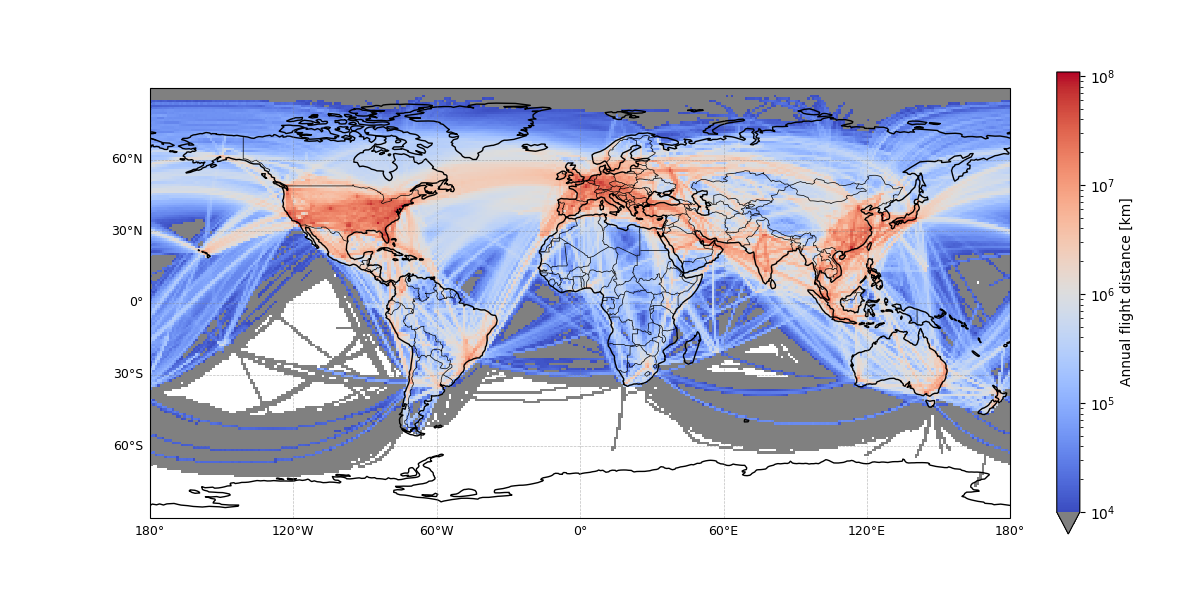

In [7]:
# AIR TRAFFIC

## Data
data = ds_new['seg_length_km'].where(np.isfinite(ds_new['seg_length_km']), np.nan)

## Bounds and norm
minimal_traffic_per_cell = 1e4
vmin = minimal_traffic_per_cell
vmax = np.nanmax(data)
norm = mcolors.LogNorm(vmin=vmin, vmax=vmax)
share = (data.where(data > vmin).sum(dim=['lat', 'lon']) / data.sum(dim=['lat', 'lon'])).item() * 100
print("Share of traffic included:", round(share, 2), "%")

## Colormap
cmap = plt.cm.coolwarm.copy()
cmap.set_bad(color=(1, 1, 1, 0))
cmap.set_under("grey") 

## Plot
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
data_plot = plt.pcolormesh(ds['lon'], ds['lat'], data,
                         transform=ccrs.PlateCarree(),
                         cmap=cmap, norm=norm)

ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.set_global()

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 9}
gl.ylabel_style = {'size': 9}

cbar = plt.colorbar(data_plot, ax=ax, extend="min", fraction=0.025)
cbar.set_label("Annual flight distance [km]", fontsize=10)

plt.show()

Mean radiative forcing: 44.0 mW/m²


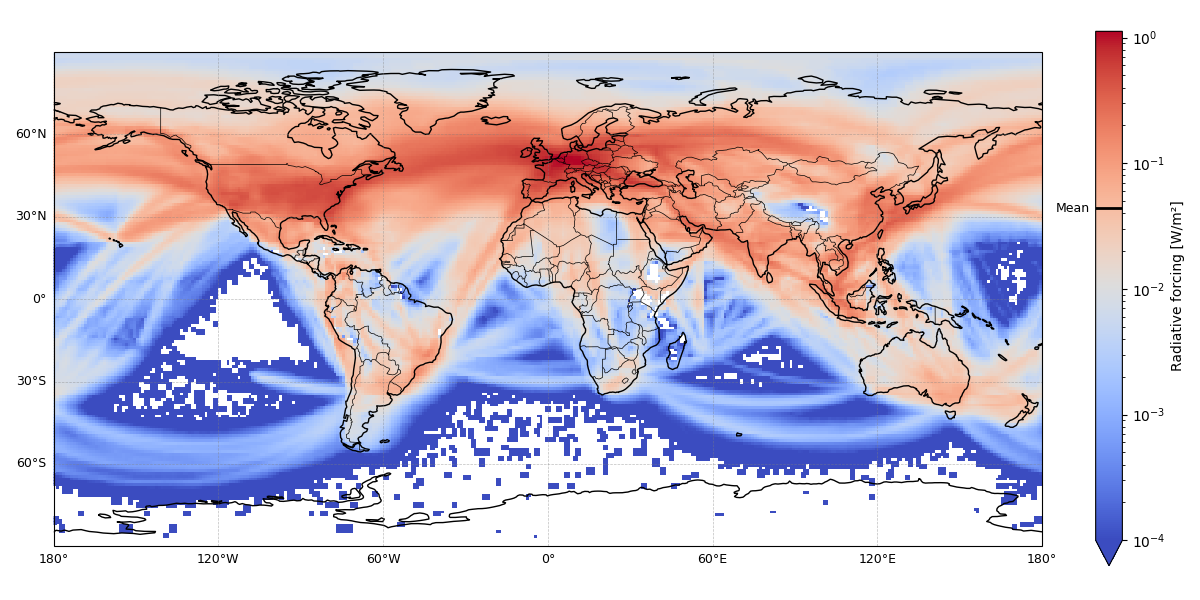

In [8]:
# NET RADIATIVE FORCING

## Data
data = ds_new['RF_net'].where(np.isfinite(ds_new['RF_net']), np.nan)
data_np = data.values
mean_rf_net = ((ds_new['RF_net'] * ds_new['areacella']).sum(dim=['lat', 'lon']).item() / ds_new['areacella'].sum(dim=['lat','lon'])).item()
print("Mean radiative forcing:", round(1000 * mean_rf_net, 1), "mW/m²")

## Bounds and norm
vmin = 1e-4
vmax = np.nanmax(data_np)
norm = mcolors.LogNorm(vmin=vmin, vmax=vmax)

## Colormap
cmap = plt.cm.coolwarm.copy()
cmap.set_bad(color=(1, 1, 1, 0))   # blanc transparent

## Plot
plt.figure(figsize=(12, 6))

ax = plt.axes(projection=ccrs.PlateCarree())
data_plot = plt.pcolormesh(ds['lon'], ds['lat'], data_np,
                         transform=ccrs.PlateCarree(),
                         cmap=cmap, norm=norm)

ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.set_global()

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 9}
gl.ylabel_style = {'size': 9}

cbar = plt.colorbar(data_plot, ax=ax, extend='min', fraction=0.025)
cbar.ax.axhline(mean_rf_net, color='black', linewidth=2)
cbar.ax.text(-0.2, mean_rf_net, 'Mean', va='center', ha='right', color='black', fontsize=9, transform=cbar.ax.get_yaxis_transform())
cbar.set_label("Radiative forcing [W/m²]", fontsize=10)

plt.tight_layout()
plt.show()

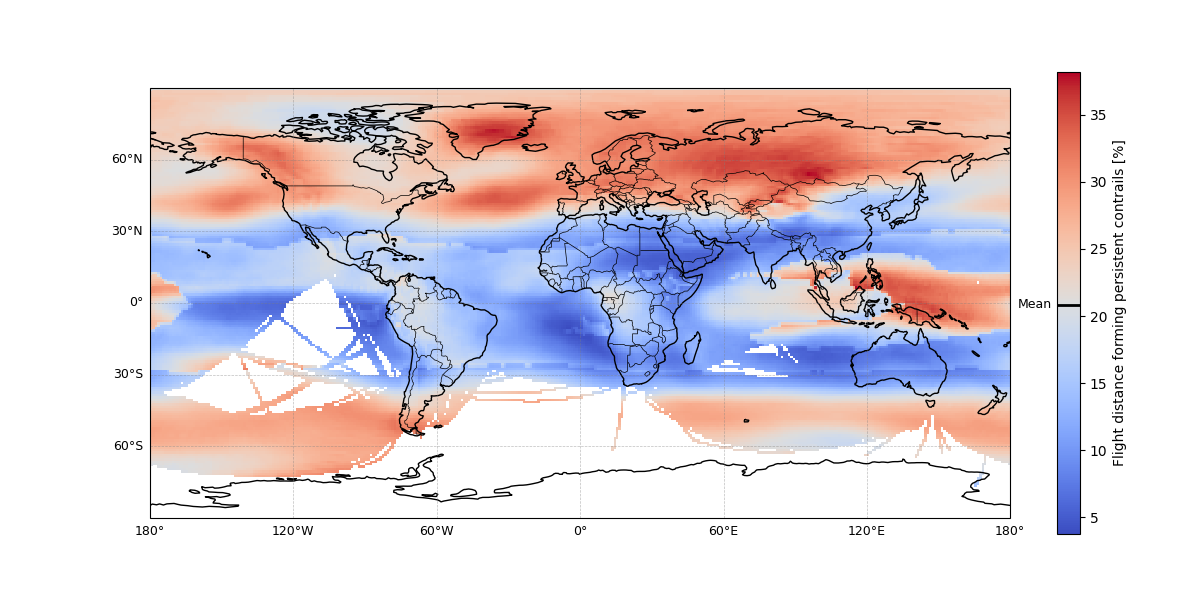

In [9]:
# CONTRAILS COVERAGE

## Data
data = ds_new['seg_length_contrail_km'].where(np.isfinite(ds_new['seg_length_contrail_km']), np.nan)/ds_new['seg_length_km'].where(np.isfinite(ds_new['seg_length_km']), np.nan) * 100
mean_contrails_share = data.mean().item()
data_np = data.values

## Bounds and norm
vmin = np.nanmin(data)
vmax = np.nanmax(data)
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

## Colormap
cmap = plt.cm.coolwarm.copy()
cmap.set_bad(color=(1, 1, 1, 0))   # blanc transparent

## Plot
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
data_plot = plt.pcolormesh(ds_new['lon'], ds_new['lat'], data_np,
                         transform=ccrs.PlateCarree(),
                         cmap=cmap, norm=norm)

ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.set_global()

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 9}
gl.ylabel_style = {'size': 9}

cbar = plt.colorbar(data_plot, ax=ax, extend=None, fraction=0.025)
cbar.ax.axhline(mean_contrails_share, color='black', linewidth=2)
cbar.ax.text(-0.2, mean_contrails_share, 'Mean', va='center', ha='right', color='black', fontsize=9, transform=cbar.ax.get_yaxis_transform())
cbar.set_label("Flight distance forming persistent contrails [%]", fontsize=10)

plt.show()

## Metric analyses

In [10]:
metric_function = ratr_contrails
time_horizon = 100
metric_label = rf"$r\text{{-}}ATR_{{{time_horizon}}}$"

ratio_erf_rf_contrails = 0.42
efficacy_erf_contrails = 1

Mean metric: 3.9


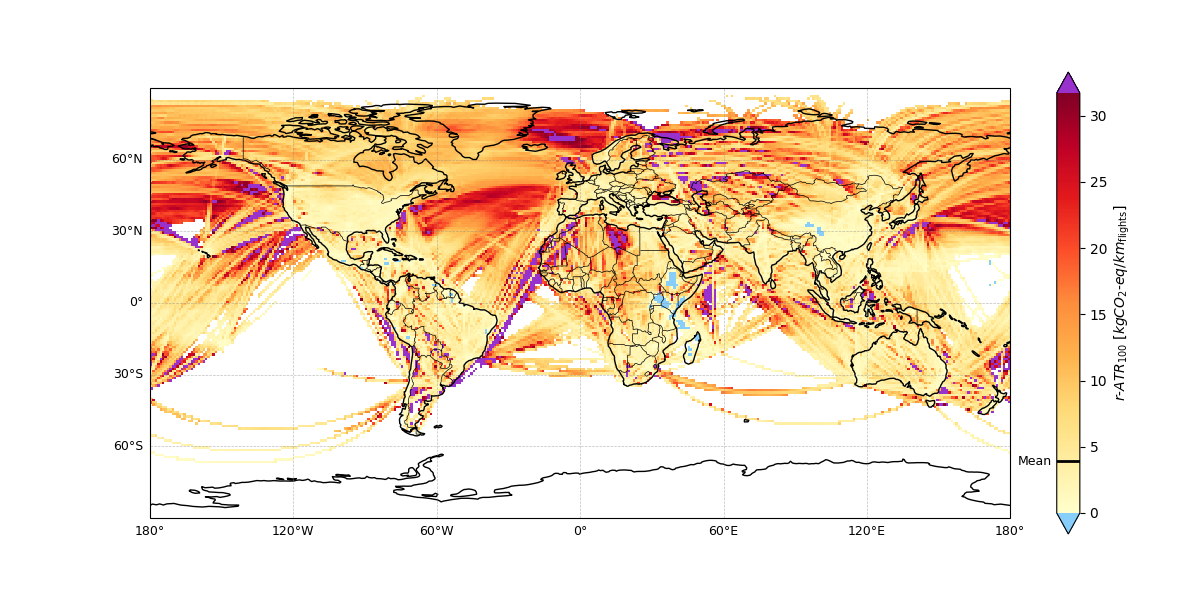

In [11]:
# Data
ds_new['Metric_flights'] = metric_function(time_horizon, ds_new['RF_flight_distance_normalised'], ratio_erf_rf_contrails, efficacy_erf_contrails)
metric_flights_i = ds_new['Metric_flights'] * ds_new['seg_length_km'].where(np.isfinite(ds_new['seg_length_km']), np.nan) / ds_new['seg_length_km'].sum(dim=['lat', 'lon']).item()
mean_metric_flights = metric_flights_i.sum().item()
print("Mean metric:", round(mean_metric_flights, 2))


# Plot data
minimal_traffic_per_cell = 1e4
data_masked_flights = ds_new['Metric_flights'].where(ds_new['seg_length_km'] >= minimal_traffic_per_cell)
data_np_flights = data_masked_flights.values


# Plot settings

## Bounds and norm
vmin = 0
vmax = data_masked_flights.quantile(0.97)
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

## Colormap
cmap = plt.cm.YlOrRd
cmap.set_bad(color=(1,1,1,0))
cmap.set_under('lightskyblue')
cmap.set_over('darkorchid')


# Plot
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.set_global()

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 9}
gl.ylabel_style = {'size': 9}

data_plot = ax.pcolormesh(ds_new['Metric_flights']['lon'], ds_new['Metric_flights']['lat'], data_np_flights,
                    cmap=cmap, norm=norm,
                    transform=ccrs.PlateCarree())

cbar = plt.colorbar(data_plot, ax=ax, extend='both', fraction=0.025)
cbar.ax.axhline(mean_metric_flights, color='black', linewidth=2)
cbar.ax.text(-0.2, mean_metric_flights, 'Mean', va='center', ha='right', color='black', fontsize=9, transform=cbar.ax.get_yaxis_transform())
cbar.set_label(metric_label+ r" [$kgCO_2\text{-}eq/km_{\text{flights}}$]", fontsize=10)

plt.savefig("figures/map_sensitivity_flight_distance.pdf")
plt.show()

Mean metric: 19.82


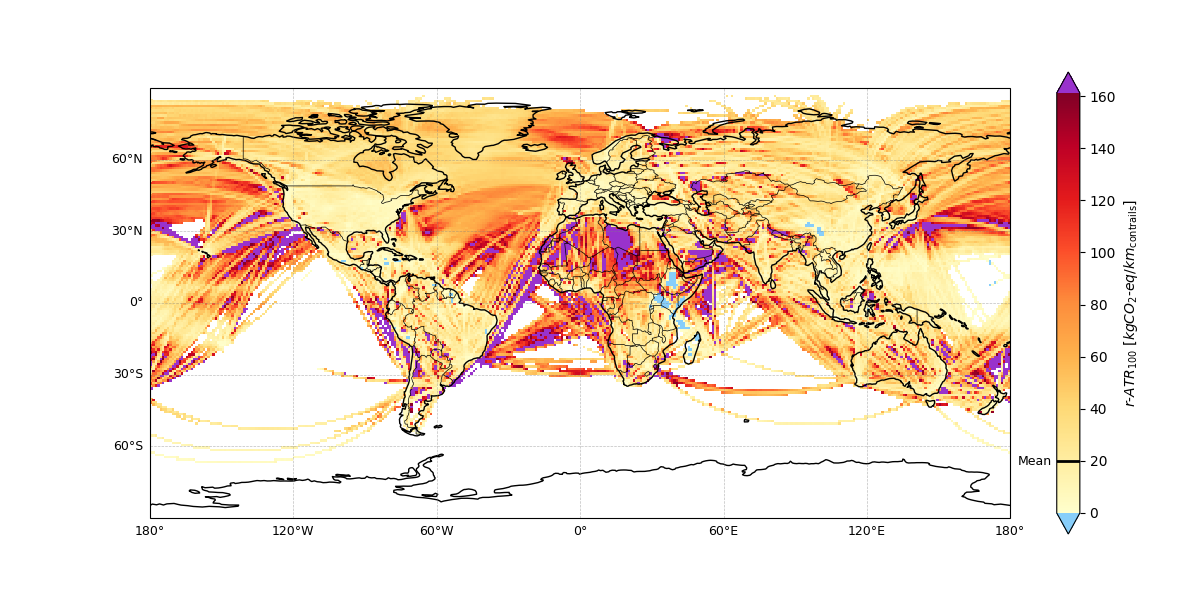

In [12]:
# Data
ds_new['Metric_contrails'] = metric_function(time_horizon, ds_new['RF_contrails_distance_normalised'], ratio_erf_rf_contrails, efficacy_erf_contrails)
metric_contrails_i = ds_new['Metric_contrails'] * ds_new['seg_length_km'].where(np.isfinite(ds_new['seg_length_km']), np.nan) / ds_new['seg_length_km'].sum(dim=['lat', 'lon']).item()
mean_metric_contrails = metric_contrails_i.sum().item()
print("Mean metric:", round(mean_metric_contrails, 2))


# Plot data
minimal_traffic_per_cell = 1e4
data_masked_contrails = ds_new['Metric_contrails'].where(ds_new['seg_length_km'] >= minimal_traffic_per_cell)
data_np_contrails = data_masked_contrails.values


# Plot settings

## Bounds and norm
vmin = 0
vmax = data_masked_flights.quantile(0.97) * mean_metric_contrails / mean_metric_flights
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# ## Check values above maximum
# mask = data_masked_contrails >= data_masked_flights.quantile(0.97) * mean_metric_contrails / mean_metric_flights
# count_sup = mask.sum().item()
# total = data_masked.count().item()
# fraction = count_sup / total
# print(f"{count_sup}/{total} ({fraction:.2%})")

## Colormap
cmap = plt.cm.YlOrRd
cmap.set_bad(color=(1,1,1,0))
cmap.set_under('lightskyblue')
cmap.set_over('darkorchid')


# Plot
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.set_global()

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 9}
gl.ylabel_style = {'size': 9}

data_plot = ax.pcolormesh(ds_new['Metric_contrails']['lon'], ds_new['Metric_contrails']['lat'], data_np_contrails,
                    cmap=cmap, norm=norm,
                    transform=ccrs.PlateCarree())

cbar = plt.colorbar(data_plot, ax=ax, extend='both', fraction=0.025)
cbar.ax.axhline(mean_metric_contrails, color='black', linewidth=2)
cbar.ax.text(-0.2, mean_metric_contrails, 'Mean', va='center', ha='right', color='black', fontsize=9, transform=cbar.ax.get_yaxis_transform())
cbar.set_label(metric_label+ r" [$kgCO_2\text{-}eq/km_{\text{contrails}}$]", fontsize=10)

plt.savefig("figures/map_sensitivity_contrails_distance.pdf")
plt.show()